<a href="https://colab.research.google.com/github/lab-jianghao/spark_ml_sample/blob/main/06_normal_distribution_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-17-jdk-headless

!wget https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz /content
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
!pip install pyspark==3.5.0

In [4]:
from functools import wraps
from pyspark.sql import SparkSession

def spark_sql_initializer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        spark = SparkSession.builder\
            .appName("Colab_SPARK_ML")\
            .master("local[*]")\
            .getOrCreate()

        spark.sparkContext.setLogLevel("WARN")

        func(spark,*args, **kwargs)

        spark.stop()

    return wrapper

In [5]:
from sklearn.datasets import fetch_openml

import pandas as pd

airfoil_self_noise = fetch_openml(name="airfoil_self_noise", version=1, as_frame=True)

df = pd.concat([airfoil_self_noise.data, airfoil_self_noise.target], axis=1)
df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,frequency,angle,length,velocity,thickness,pressure
0,800.0,0.0,0.3048,71.3,0.002663,126.201
1,1000.0,0.0,0.3048,71.3,0.002663,125.201
2,1250.0,0.0,0.3048,71.3,0.002663,125.951
3,1600.0,0.0,0.3048,71.3,0.002663,127.591
4,2000.0,0.0,0.3048,71.3,0.002663,127.461


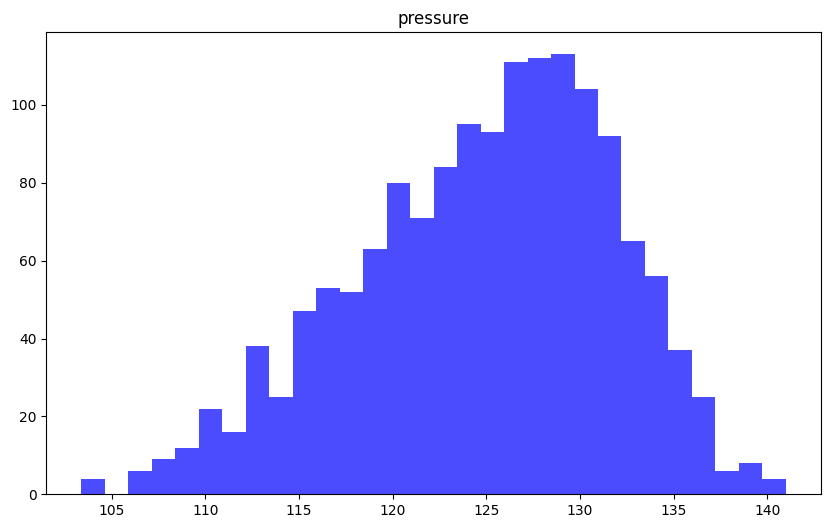

In [14]:
import matplotlib.pyplot as plt

target_column = airfoil_self_noise.target.name

plt.figure(figsize=(10, 6))
plt.hist(df[target_column], bins=30, color='blue', alpha=0.7)
plt.title(target_column)
plt.show()

#normal distribution

In [61]:
from ast import Pow
from functools import reduce

from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F


@spark_sql_initializer
def train_LR(spark, df):
    noise_df = spark.createDataFrame(df)
    noise_df.show()

    index_columns = noise_df.columns[:-1]
    noise_df = noise_df.withColumnRenamed("pressure", "label")

    vector_assembler = VectorAssembler(inputCols=index_columns, outputCol="features")

    lr = LinearRegression(featuresCol="features", labelCol="label", predictionCol="prediction")

    training_data, test_data = noise_df.randomSplit([0.7, 0.3], seed=1000)

    lr_pipeline = Pipeline(stages=[vector_assembler, lr])
    lr_model = lr_pipeline.fit(training_data)
    lr_prediction = lr_model.transform(test_data)

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(lr_prediction)
    print("Root Mean Squared Error (RMSE) = {:.2f}".format(rmse))

    lr_prediction.select("label", "prediction").show()

    print("-----------------------------------")
    intercept = lr_model.stages[-1].intercept
    print(f"Intercept: {intercept}")
    print("-----------------------------------")

    feature_weights = lr_model.stages[-1].coefficients
    feature_weights_dict = dict(zip(index_columns, feature_weights))

    sorted_weights = sorted(feature_weights_dict.items(), key=lambda x: abs(x[1]), reverse=True)
    print("Feature Weights:")
    for feature, weight in sorted_weights:
        print(f"{feature}: {weight}")
    print("-----------------------------------")


In [62]:
train_LR(df.copy())

+---------+-----+------+--------+----------+--------+
|frequency|angle|length|velocity| thickness|pressure|
+---------+-----+------+--------+----------+--------+
|    800.0|  0.0|0.3048|    71.3|0.00266337| 126.201|
|   1000.0|  0.0|0.3048|    71.3|0.00266337| 125.201|
|   1250.0|  0.0|0.3048|    71.3|0.00266337| 125.951|
|   1600.0|  0.0|0.3048|    71.3|0.00266337| 127.591|
|   2000.0|  0.0|0.3048|    71.3|0.00266337| 127.461|
|   2500.0|  0.0|0.3048|    71.3|0.00266337| 125.571|
|   3150.0|  0.0|0.3048|    71.3|0.00266337| 125.201|
|   4000.0|  0.0|0.3048|    71.3|0.00266337| 123.061|
|   5000.0|  0.0|0.3048|    71.3|0.00266337| 121.301|
|   6300.0|  0.0|0.3048|    71.3|0.00266337| 119.541|
|   8000.0|  0.0|0.3048|    71.3|0.00266337| 117.151|
|  10000.0|  0.0|0.3048|    71.3|0.00266337| 115.391|
|  12500.0|  0.0|0.3048|    71.3|0.00266337| 112.241|
|  16000.0|  0.0|0.3048|    71.3|0.00266337| 108.721|
|    500.0|  0.0|0.3048|    55.5|0.00283081| 126.416|
|    630.0|  0.0|0.3048|    